# Importing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from datetime import datetime, timedelta
import warnings
import seaborn as sns
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', 200)
RANDOM_SEED = 27
current_date = pd.to_datetime('12/01/2021')

# 1.1 Basic look at the dataset

In [2]:
df = pd.read_csv('main_task.csv')

In [3]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [4]:
df.columns = ['id','city', 'cuisine', 'ranking', 'rating',
              'prices', 'number_of_reviews', 'reviews', 'url',
              'website_id']

In [5]:
''' URL_TA is irrelavent for the model, so they will be dropped
for the sake of simplifying the data frame. '''
df.drop(['url'], inplace=True, axis=1)

In [6]:
df.nunique(dropna=False)

id                   11909
city                    31
cuisine               9008
ranking              11936
rating                   9
prices                   4
number_of_reviews     1460
reviews              33516
website_id           39980
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine            30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   prices             26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
 8   website_id         40000 non-null  object 
dtypes: float64(3), object(6)
memory usage: 2.7+ MB


# 1.2 restaraunt ID

In [8]:
df.id.value_counts()

id_871      18
id_436      18
id_227      18
id_633      18
id_534      17
            ..
id_8357      1
id_15384     1
id_14345     1
id_7092      1
id_14756     1
Name: id, Length: 11909, dtype: int64

In [9]:
df.id = df.id.apply(lambda x: x[3:])

# 1.3 Cities

In [10]:
# check if there are any repetitions/alternative notations for city names
df.city.value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: city, dtype: int64

# 1.4 Cuisine

In [11]:
df.cuisine[0], type(df.cuisine[0])

("['European', 'French', 'International']", str)

# 1.5 Ranking

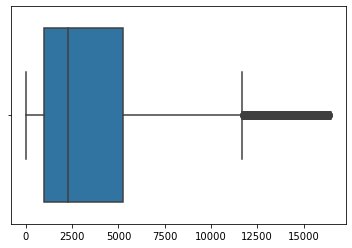

In [12]:
sns.boxplot(df.ranking.values)

In [13]:
df[['rating', 'ranking']].corr()

,rating,ranking
rating,1.000000,-0.368371
ranking,-0.368371,1.000000


# 1.6 Price Range

In [14]:
df['prices'].value_counts(dropna=False)

$$ - $$$    18412
NaN         13886
$            6279
$$$$         1423
Name: prices, dtype: int64

In [15]:
# price range is hard to read using the original notation, so
# it is converted into categorical data
def price_range_sort(price):
    if price == '$$ - $$$':
        price = 'medium'
    elif price == '$':
        price = 'budget'
    elif price == '$$$$':
        price = 'expensive'
    return price


df['filled_budget'] = df[df.prices.isna()].prices.apply(lambda x: 1)
df['filled_budget'] = df['filled_budget'].fillna(0)
df.prices = df.prices.fillna('unspecified_budget').apply(price_range_sort)

# 1.7 Number of Reviews & Reviews

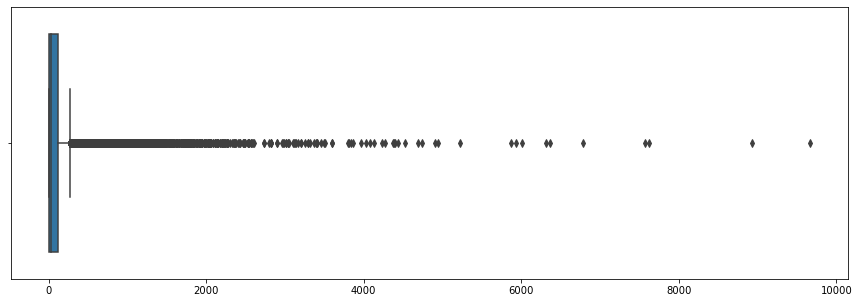

In [16]:
plt.figure(figsize = (15, 5))
sns.boxplot(df.number_of_reviews.values)

In [17]:
df.reviews[0], type(df.reviews[0])

("[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]",
 str)

# 2. Exploratory Data Analysis

# 2.1 restaurant id

In [18]:
# from 1.1 it can be seen that certain restaurants have the same id,
# since there are only 11909 for 40000 different restaurants, which
# means certain restaurants form a chain
chain_restaurant = df.id.value_counts()[df.id.value_counts() > 1].index.tolist()
df['chain_restaurant'] = df[df.id.isin(chain_restaurant)].id.apply(lambda x: 1)
df.chain_restaurant = df['chain_restaurant'].fillna(0)

# 2.2 shared website id

In [19]:
# just a few restaurants have a shared website id
shared_web = df.website_id.value_counts()[df.website_id.value_counts() > 1].index.to_list()
df['shared_web'] = df[df.website_id.isin(shared_web)].website_id.apply(lambda x : 1)
df['shared_web'] = df['shared_web'].fillna(0)

# 2.3 Cuisine

In [20]:
def separation(data):
    '''Function for separation of certain data in the dataset.
       Function takes in a string and returns a
       list of elements of the string'''
    data = data.replace('[','')
    data = data.replace(']','')
    data = data.replace('\'','')
    data = data.lower()
    data = data.split(',')
    data = [element.strip() for element in data]
    return data

In [21]:
df['filled_cuisine'] = df[df.cuisine.isna()].cuisine.apply(lambda x: 1)
df['filled_cuisine'] = df['filled_cuisine'].fillna(0)

In [22]:
df.cuisine = df.cuisine.fillna('other_cuisine').apply(separation)
cuisine_exploded = df.explode('cuisine')
pd.DataFrame(cuisine_exploded.cuisine.value_counts())

,cuisine
vegetarian friendly,11189
european,10060
other_cuisine,9283
mediterranean,6277
italian,5964
...,...
xinjiang,1
burmese,1
latvian,1
salvadoran,1


In [23]:
popular_cuisine_dict = {}
cities = df.city.unique()
for city in cities:
    most_popular_cuisine = cuisine_exploded[cuisine_exploded['city'] == city].cuisine.value_counts().index[0]
    popular_cuisine_dict[city] = most_popular_cuisine
popular_cuisine_dict

{'Paris': 'french',
 'Stockholm': 'european',
 'London': 'vegetarian friendly',
 'Berlin': 'other_cuisine',
 'Munich': 'vegetarian friendly',
 'Oporto': 'european',
 'Milan': 'italian',
 'Bratislava': 'other_cuisine',
 'Vienna': 'european',
 'Rome': 'italian',
 'Barcelona': 'spanish',
 'Madrid': 'spanish',
 'Dublin': 'vegetarian friendly',
 'Brussels': 'european',
 'Zurich': 'vegetarian friendly',
 'Warsaw': 'european',
 'Budapest': 'european',
 'Copenhagen': 'european',
 'Amsterdam': 'european',
 'Lyon': 'french',
 'Hamburg': 'other_cuisine',
 'Lisbon': 'european',
 'Prague': 'european',
 'Oslo': 'european',
 'Helsinki': 'european',
 'Edinburgh': 'vegetarian friendly',
 'Geneva': 'european',
 'Ljubljana': 'european',
 'Athens': 'greek',
 'Luxembourg': 'european',
 'Krakow': 'european'}

In [24]:
df['most_popular_cuisine'] = df.city.map(popular_cuisine_dict)

In [25]:
df['most_popular_cuisine']

0                     french
1                   european
2        vegetarian friendly
3              other_cuisine
4        vegetarian friendly
                ...         
39995                italian
39996                 french
39997               european
39998               european
39999                italian
Name: most_popular_cuisine, Length: 40000, dtype: object

In [26]:
df['diversive_cuisine'] = df.cuisine.apply(lambda x: len(x))

In [27]:
df.diversive_cuisine

0        3
1        1
2        7
3        1
4        3
        ..
39995    4
39996    5
39997    2
39998    5
39999    1
Name: diversive_cuisine, Length: 40000, dtype: int64

# 2.4 Ranking

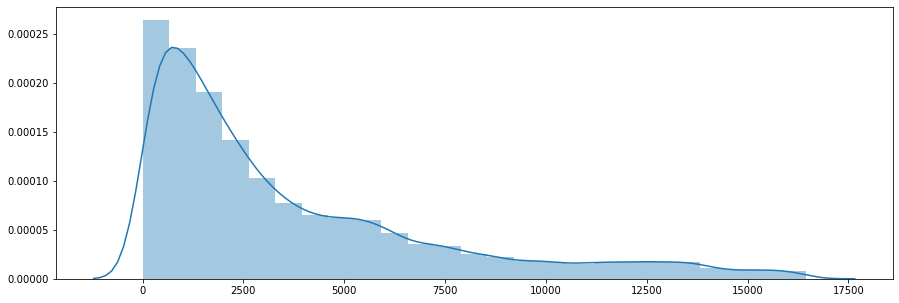

In [28]:
plt.figure(figsize=(15, 5))
sns.distplot(df.ranking.values, bins=25)

In [29]:
df['ranking'].describe()

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: ranking, dtype: float64

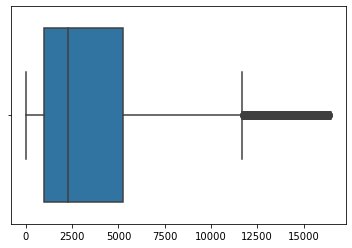

In [30]:
sns.boxplot(df.ranking.values)

Text(0, 0.5, 'Quantity (frequency)')

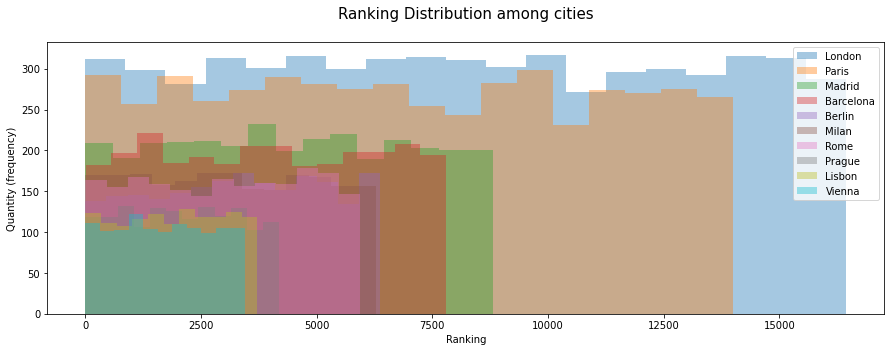

In [31]:
plt.figure(figsize=(15, 5))
for city in (df['city'].value_counts())[0:10].index:
    sns.distplot(df['ranking'][df['city'] == city], kde=False, label=city)

    
plt.legend(prop={'size': 10})
plt.title('Ranking Distribution among cities\n', fontsize=15)
plt.xlabel('Ranking')
plt.ylabel('Quantity (frequency)')

In [32]:
df['ranking_norm'] = df['ranking']/df.city.map(dict(df['city'].value_counts()))

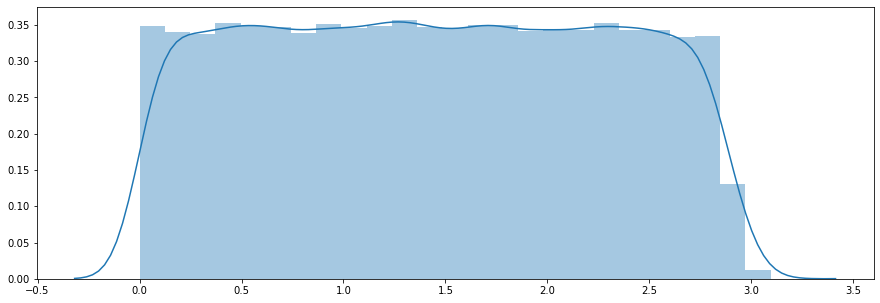

In [33]:
plt.figure(figsize=(15, 5))
sns.distplot(df.ranking_norm.values, bins=25)

In [34]:
df['ranking_norm'].describe()

count    40000.000000
mean         1.445413
std          0.834555
min          0.000174
25%          0.723119
50%          1.439623
75%          2.166667
max          3.094065
Name: ranking_norm, dtype: float64

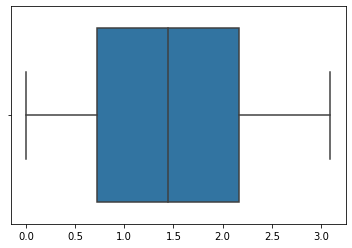

In [35]:
sns.boxplot(df.ranking_norm.values)

# Reviews and time

In [36]:
# creates a pattern that looks like
# multiple digits/digits/digits
pattern = re.compile('\d+\/\d+\/\d+')

In [37]:
df['review_date'] = df.reviews.apply(lambda x: pattern.findall(x))

In [38]:
df['number_of_reviews'].loc[df.number_of_reviews.isna()] = df.loc[df.number_of_reviews.isna()].review_date.apply(lambda x: len(x))

In [39]:
dt_review_date = df.review_date.apply(lambda x: [pd.to_datetime(i).date() for i in x])

In [40]:
df['dt_review_date'] = dt_review_date

In [41]:
dt_review_date.max()

[datetime.date(2018, 2, 26), datetime.date(2018, 2, 26)]

In [42]:
def difference(a):
    if len(a) > 1:
        b = sorted(a)
        diff = b[-1] - b[0]
        diff = int(diff.days)
        return diff
    else:
        return 0
df['time_difference'] = df.dt_review_date.apply(difference)

In [43]:
df['time_difference'].describe()

count    40000.000000
mean       102.645675
std        198.594208
min          0.000000
25%          0.000000
50%         28.000000
75%        120.000000
max       3207.000000
Name: time_difference, dtype: float64

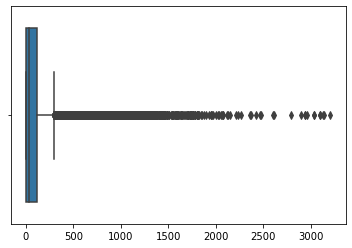

In [44]:
sns.boxplot(df['time_difference'].values)

In [45]:
data = [[2.2, 105], [1, 188], [8.9, 1706], 
         [3.6, 891], [1.5, 310], [0.3, 41.4], 
         [1.4, 181], [0.4, 368], [1.9, 414], 
         [2.9, 1287], [1.7, 101], [3.3, 607], 
         [1.2, 117], [0.2, 32.6], [0.4, 88], 
         [1.8, 517], [1.8, 525], [0.8, 86.4], 
         [0.9, 219], [0.5, 48], [1.9, 755], 
         [0.5,100], [1.3, 496], [0.7, 454], 
         [0.7,213], [0.5, 120], [0.2, 16], 
         [0.3, 163], [0.7, 39], [0.125, 51.5], 
         [0.8, 327]]
city_dict = {}
for i in range(len(cities)):
    city_dict[cities[i]] = data[i] 
city_dict

{'Paris': [2.2, 105],
 'Stockholm': [1, 188],
 'London': [8.9, 1706],
 'Berlin': [3.6, 891],
 'Munich': [1.5, 310],
 'Oporto': [0.3, 41.4],
 'Milan': [1.4, 181],
 'Bratislava': [0.4, 368],
 'Vienna': [1.9, 414],
 'Rome': [2.9, 1287],
 'Barcelona': [1.7, 101],
 'Madrid': [3.3, 607],
 'Dublin': [1.2, 117],
 'Brussels': [0.2, 32.6],
 'Zurich': [0.4, 88],
 'Warsaw': [1.8, 517],
 'Budapest': [1.8, 525],
 'Copenhagen': [0.8, 86.4],
 'Amsterdam': [0.9, 219],
 'Lyon': [0.5, 48],
 'Hamburg': [1.9, 755],
 'Lisbon': [0.5, 100],
 'Prague': [1.3, 496],
 'Oslo': [0.7, 454],
 'Helsinki': [0.7, 213],
 'Edinburgh': [0.5, 120],
 'Geneva': [0.2, 16],
 'Ljubljana': [0.3, 163],
 'Athens': [0.7, 39],
 'Luxembourg': [0.125, 51.5],
 'Krakow': [0.8, 327]}

In [46]:
df['population_and_area'] = df.city.map(city_dict)

In [47]:
# df['population'] = df['population_and_area'].apply(lambda x: x[0])
# df['area'] = df['population_and_area'].apply(lambda x: x[1])
df['population_density'] = df['population_and_area'].apply(lambda x: x[0]/x[1])
df.drop(['population_and_area'], inplace=True, axis=1)

In [48]:
# creating dummies
city_dummies = pd.get_dummies(df.city)
cuisine_dummies = pd.get_dummies(df.cuisine.apply(pd.Series).stack()).sum(level = 0)
prices_dummies = pd.get_dummies(df.prices)

# 3.x Correlations

In [49]:
correlations = df.corr()

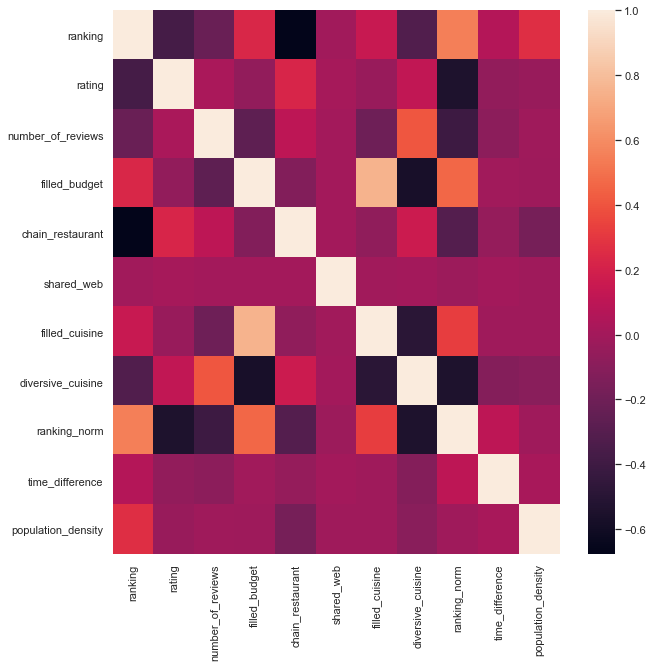

In [50]:
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
sns.heatmap(correlations)

In [51]:
correlations['chain_restaurant'].sort_values()

ranking              -0.675937
ranking_norm         -0.306396
population_density   -0.169235
filled_budget        -0.120078
filled_cuisine       -0.070235
time_difference      -0.047461
shared_web            0.001731
number_of_reviews     0.103545
diversive_cuisine     0.162240
rating                0.223689
chain_restaurant      1.000000
Name: chain_restaurant, dtype: float64

In [52]:
correlations['ranking_norm'].sort_values()

rating               -0.542702
diversive_cuisine    -0.540307
number_of_reviews    -0.406296
chain_restaurant     -0.306396
shared_web           -0.021598
population_density   -0.014359
time_difference       0.106742
filled_cuisine        0.323129
filled_budget         0.463445
ranking               0.553154
ranking_norm          1.000000
Name: ranking_norm, dtype: float64

In [53]:
correlations['filled_budget'].sort_values()

diversive_cuisine    -0.566692
number_of_reviews    -0.266721
chain_restaurant     -0.120078
rating               -0.064567
population_density   -0.015204
time_difference      -0.005888
shared_web            0.000189
ranking               0.233043
ranking_norm          0.463445
filled_cuisine        0.753881
filled_budget         1.000000
Name: filled_budget, dtype: float64

In [54]:
correlations['filled_cuisine'].sort_values()

diversive_cuisine    -0.490787
number_of_reviews    -0.201260
chain_restaurant     -0.070235
rating               -0.038263
time_difference      -0.013625
population_density   -0.009283
shared_web           -0.002404
ranking               0.147995
ranking_norm          0.323129
filled_budget         0.753881
filled_cuisine        1.000000
Name: filled_cuisine, dtype: float64

In [55]:
# merging dummies with the original dataframe
final_df = df.merge(city_dummies, left_index=True, right_index=True)
final_df = final_df.merge(cuisine_dummies, left_index=True, right_index=True)
final_df = final_df.merge(prices_dummies, left_index=True, right_index=True)

In [56]:
# dropping the columns represented by dummies'city'
final_df.drop(['filled_budget', 'filled_cuisine', 'prices', 'website_id', 'city', 'id', 'cuisine', 'ranking', 'most_popular_cuisine'], inplace=True, axis=1)

In [57]:
final_df.drop(['unspecified_budget', 'chain_restaurant', 'shared_web'], inplace=True, axis = 1)

In [58]:
final_df

,rating,number_of_reviews,reviews,diversive_cuisine,ranking_norm,review_date,dt_review_date,time_difference,population_density,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,afghani,african,albanian,american,arabic,argentinean,armenian,asian,australian,austrian,azerbaijani,balti,bangladeshi,bar,barbecue,belgian,brazilian,brew pub,british,burmese,cafe,cajun & creole,cambodian,canadian,caribbean,caucasian,central american,central asian,central european,chilean,chinese,colombian,contemporary,croatian,cuban,czech,danish,delicatessen,diner,dutch,eastern european,ecuadorean,egyptian,ethiopian,european,fast food,filipino,french,fujian,fusion,gastropub,georgian,german,gluten free options,greek,grill,halal,hawaiian,healthy,hungarian,indian,indonesian,international,irish,israeli,italian,jamaican,japanese,korean,kosher,latin,latvian,lebanese,malaysian,mediterranean,mexican,middle eastern,minority chinese,mongolian,moroccan,native american,nepali,new zealand,norwegian,other_cuisine,pakistani,persian,peruvian,pizza,polish,polynesian,portuguese,pub,romanian,russian,salvadoran,scandinavian,scottish,seafood,singaporean,slovenian,soups,south american,southwestern,spanish,sri lankan,steakhouse,street food,sushi,swedish,swiss,taiwanese,thai,tibetan,tunisian,turkish,ukrainian,uzbek,vegan options,vegetarian friendly,venezuelan,vietnamese,welsh,wine bar,xinjiang,yunnan,budget,expensive,medium
0,3.5,194.0,"[['Good food at your doorstep', 'A good hotel ...",3,1.137431,"[12/31/2017, 11/20/2017]","[2017-12-31, 2017-11-20]",41,0.020952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,4.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",1,1.874390,"[07/06/2017, 06/19/2016]","[2017-07-06, 2016-06-19]",382,0.005319,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.5,688.0,"[['Catch up with friends', 'Not exceptional'],...",7,0.061317,"[01/08/2018, 01/06/2018]","[2018-01-08, 2018-01-06]",2,0.005217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
3,5.0,3.0,"[[], []]",1,1.604640,[],[],0,0.004040,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.0,84.0,"[['Best place to try a Bavarian food', 'Nice b...",3,0.695409,"[11/18/2017, 02/19/2017]","[2017-11-18, 2017-02-19]",272,0.004839,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [59]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = final_df.drop(['rating', 'reviews', 'review_date', 'dt_review_date'], axis = 1)
y = final_df['rating']

In [60]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [61]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = RANDOM_SEED)

# Создаём, обучаем и тестируем модель

In [62]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [63]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [64]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.209625


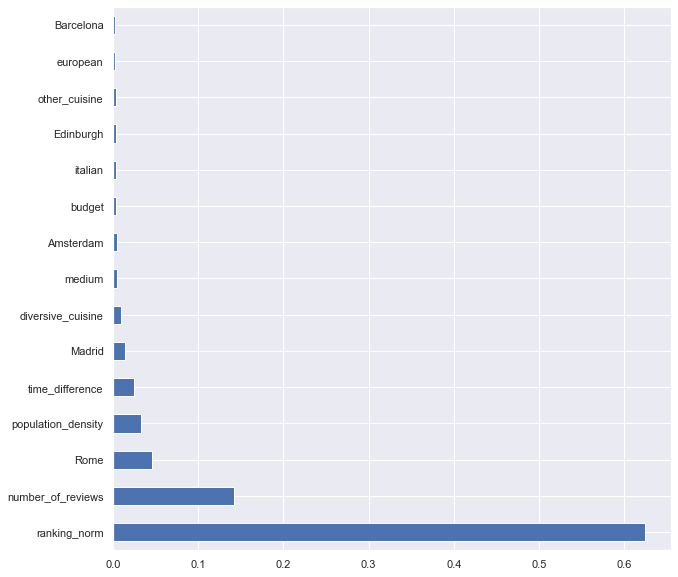

In [65]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [66]:
0.20913199999999998 0.2090655

SyntaxError: invalid syntax (<ipython-input-66-1ec2faacc6d2>, line 1)